In [1]:
from __future__ import division, unicode_literals, print_function  # for compatibility with Python 2 and 3

import matplotlib.pyplot as mpl 
import matplotlib.pyplot as plt

%matplotlib inline

# Optionally, tweak styles.
mpl.rc('figure',  figsize=(10, 5))
mpl.rc('image', cmap='gray')
import numpy as np
import pandas as pd
from pandas import DataFrame, Series  # for convenience
from scipy.optimize import curve_fit
import os
from numpy import asarray
from numpy import savetxt

In [3]:
import pims
import pySPM as spm 
import trackpy as tp
import glob
from scipy import ndimage, misc
from sxmreader import SXMReader
    
if False:
    frames = SXMReader("-60VG_dense_02102020/*.sxm")
    molecule_size = 13
    min_mass = 5.0
    min_size = 15.0
    max_ecc = 0.3
if False:
    frames = SXMReader("data_high_density/*.sxm")
    molecule_size = 21
    min_mass = 5.0
    min_size = 4.0
    max_ecc = 0.3
if False:
    frames = SXMReader("examples/gate_dep/*.sxm")
    molecule_size = 7
    min_mass = 0.1
    min_size = 1.0
    max_ecc = 0.3
if False:
    frames = SXMReader("electromigration_6/Image_951.sxm") # Moire perfect lattice
    molecule_size = 11
    min_mass = 1.0
    min_size = 1.0
    max_ecc = 0.5
if False:
    frames = SXMReader("electromigration_6/Image_951.sxm")
    molecule_size = 11
    min_mass = 1.0
    min_size = 1.0
    max_ecc = 0.5
if False:
    frames = SXMReader("radial distribution_12052019/*.sxm")
    molecule_size = 7
    min_mass = 0.1
    min_size = 1.0
    max_ecc = 0.3
if True:
    frames = SXMReader(["electromigration_18/Image_195.sxm"])
    molecule_size = 7
    min_mass = 0.5
    min_size = 1.0
    max_ecc = 0.3
#print(frames[0])
    
#plt.imshow(frames[7])

Frame 0: 123 features


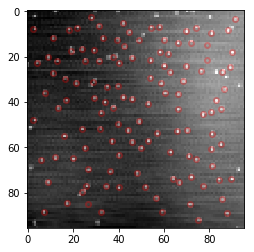

In [4]:
frame_id = 0
features = tp.batch(frames, molecule_size, minmass=min_mass, separation=3)
tp.annotate(features[features['frame']==frame_id], frames[frame_id], plot_style={'markersize' : 5, 'alpha':0.3})

scaled_features = features.copy()
scaled_features['x'] *= frames.meters_per_pixel*1e9
scaled_features['y'] *= frames.meters_per_pixel*1e9

In [7]:
import seaborn as sns
import scipy.stats as sts

In [ ]:
np.savetxt('radial_bins_gas.txt', e * frames.meters_per_pixel / 1e-9)

(0, 30)

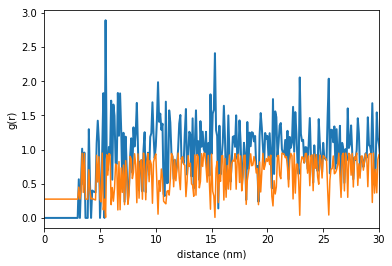

In [26]:
e, h = tp.static.pair_correlation_2d(features, 40, dr=0.1)
plt.plot(e[1:], h, lw=2)
kernel = sts.gaussian_kde(h)
plt.plot(e[1:], kernel(h))
plt.xlabel('distance (nm)')
plt.ylabel('g(r)')
plt.xlim(0, 30)

In [91]:
boundary = (0, frames.frame_shape[0], 0, frames.frame_shape[1])
print(boundary)

(0, 192, 0, 192)


In [92]:
def lerp(a, b, t):
    return a*(1.0-t)+b*t

In [93]:
frames.meters_per_pixel*192

2e-07

In [103]:
from trackpy.utils import cKDTree, guess_pos_columns
from trackpy.static import MAX_ARRAY_SIZE 
# modified from pair_correlation_2d
def angular_correlation(feat, search_radius=None, search_radius_factor=2, fraction=1., dtheta=np.pi*0.025, dr=None, dr_factor=None, p_indices=None,
                        ndensity=None, boundary=None, handle_edge=True,
                        max_rel_ndensity=10, remove_nearest_neighbor=True, radial_only=False):
    """Calculate the angular distribution function in 2 dimensions.
    Parameters
    ----------
    feat : Pandas DataFrame
        DataFrame containing the x and y coordinates of particles
    search_radius : float
        Maximum distance to calculate g(r)
    search_radius_factor : float
        if search_radius is not specified, specifies search_radius in approximate lattice constants, estimated from the density
    fraction : float, optional
        The fraction of particles to calculate g(r) with. May be used to
        increase speed of function. Particles selected at random.
    dtheta : float, optional
        The bin width
    p_indices : list or ndarray, optional
        Only consider a pair of particles if one of them is in 'p_indices'.
        Uses zero-based indexing, regardless of how 'feat' is indexed.
    ndensity : float, optional
        Density of particle packing. If not specified, density will be
        calculated assuming rectangular homogeneous arrangement.
    boundary : tuple, optional
        Tuple specifying rectangular prism boundary of particles (xmin, xmax,
        ymin, ymax). Must be floats. Default is to assume a rectangular packing.
        Boundaries are determined by edge particles.
    handle_edge : boolean, optional
        If true, compensate for reduced area around particles near the edges.
    max_rel_ndensity : number, optional
        The relative maximum density deviation, used to estimate the maximum
        number of neighbours. Lower numbers increase performance, until the
        method fails because there are more neighbours than expected.
    remove_nearest_neighbor : boolean, optional
        If true, the nearest neighbor of each point is excluded to avoid a giant peak at theta = 0.
    Returns
    -------
    r_edges : array
        The bin edges, with 1 more element than g_r.
    g_r : array
        The values of g_r.
    """

    if boundary is None:
        xmin, xmax, ymin, ymax = (feat.x.min(), feat.x.max(),
                                  feat.y.min(), feat.y.max())
    else:
        xmin, xmax, ymin, ymax = boundary
        
    n_particles = feat.x.count() - 1
    if ndensity is None:  # particle packing density
        ndensity = (n_particles) / ((xmax - xmin) * (ymax - ymin))

    lattice_constant = np.sqrt(1/ndensity)
    if search_radius is None:
        search_radius = search_radius_factor*lattice_constant

    if boundary is not None:
        # Disregard all particles outside the bounding box
        search_feat = feat[(feat.x >= xmin+search_radius) & (feat.x <= xmax-search_radius) &
                           (feat.y >= ymin+search_radius) & (feat.y <= ymax-search_radius)]
    if p_indices is None:
        if fraction == 1.:
            p_indices = slice(len(search_feat))
        else:  # grab random sample of particles
            p_indices = np.random.randint(0, len(search_feat),
                                          int(fraction * len(search_feat)))

    # radii bins to search for particles
    theta_edges = np.arange(-np.pi, np.pi+dtheta, dtheta)

    # initialize kdtree for fast neighbor search
    ckdtree = cKDTree(feat[['x', 'y']])
    pos = np.array(search_feat[['x','y']][p_indices])

    # Estimate upper bound for neighborhood particle count
    max_p_count = int(np.pi * (search_radius)**2 *
                      ndensity * max_rel_ndensity)
    # Protect against too large memory usage
    if len(pos) * max_p_count > MAX_ARRAY_SIZE:
          raise MemoryError('The distance array will be larger than the maximum '
                          'allowed size. Please reduce the search_radius or '
                          'max_rel_ndensity. Or run the analysis on a fraction '
                          'of the features using the fraction parameter.')

    dist, idxs = ckdtree.query(pos, k=max_p_count, distance_upper_bound=search_radius)
    if np.any(np.isfinite(dist[:, -1])):
        raise RuntimeError("There are too many particle pairs per particle. "
                           "Apparently, density fluctuations are larger than "
                           "max_rel_ndensity. Please increase it.")

    # drop zero and infinite dist values
    mask = (dist > 0) & np.isfinite(dist)
    #dist = dist[mask]
    dist = np.array([d[m] for d,m in zip(dist, mask)])
    idxs = np.array([i[m] for i,m in zip(idxs, mask)])
    neighbor_pos = np.array([ckdtree.data[i] for i in idxs])
    thetas = np.array([np.arctan2(ckdtree.data[i].T[1]-pos[n][1], ckdtree.data[i].T[0]-pos[n][0]) for n, i in enumerate(idxs)])
    theta_0s = np.array([theta[0] for theta in thetas])
    print(thetas)
    if(remove_nearest_neighbor):
        thetas = [theta[1:] for theta in thetas]
        dist = [d[1:] for d in dist]
    thetas -= theta_0s
    thetas = np.concatenate(thetas)
    if dr_factor is not None:
        dr = dr_factor*lattice_constant 
    if dr is not None:
        dist = np.concatenate(dist)
        r_edges = np.arange(0, search_radius+dr, dr)
        if radial_only:
            r_distribution = np.histogram(dist, bins=r_edges, weights=1.0/(dr*2*np.pi*dist))[0]/len(pos)
            return r_distribution, r_edges
        distribution, theta_edges, r_edges = np.histogram2d(thetas, dist, [theta_edges, r_edges], weights=1.0/(dr*2*np.pi*dist))
        distribution /= len(pos) 
        return distribution, theta_edges, r_edges
    theta_distribution = np.histogram(thetas, bins=theta_edges)[0]
    return theta_distribution, theta_edges

def multiple_gaussian(x, *params):
    y = np.zeros_like(x)
    mu = 0
    for i in range(0, len(params), 3):
        mu += params[i]
        A = params[i+1]
        sigma = params[i+2]
        y = y + A*np.exp( -0.5*((x - mu)/sigma)**2)
    return y 

def plot_stuff(f):
    print('finding theta_distribution')
    theta_distribution, theta_edges = angular_correlation(f, search_radius_factor = 1.0, dtheta=np.pi/50, boundary=boundary, remove_nearest_neighbor=True)
    theta_centers = 0.5*(theta_edges[1:]+theta_edges[:-1])
    bar_width = theta_edges[1]-theta_edges[0]
    
    frame_id = f['frame'].values[0]
    filename = frames.filenames[frame_id]
    base_path = filename[:filename.find('\\')]
    base_filename = filename[filename.find('\\')+1:]
    base_filename = base_filename[:base_filename.find('.')]
    
    ax = plt.subplot(121, polar=True)
    ax.set_xticks(np.linspace(0, 2*np.pi, 6, endpoint=False))
    ax.bar(theta_edges[:-1], theta_distribution, bar_width, yerr=np.sqrt(theta_distribution))
    bottom, top = ax.get_ylim()
    ax.set_ylim((bottom-20, top))
    
    print('finding full_distribution')
    full_distribution, theta_edges, r_edges = angular_correlation(f, search_radius_factor = 1.0, dtheta=np.pi/50, dr_factor=1.0, boundary=boundary, remove_nearest_neighbor=True)
    full_distribution /= (frames.meters_per_pixel*1e9)**2
    r_edges *= frames.meters_per_pixel*1e9
    #theta_centers = 0.5*(theta_edges[1:]+theta_edges[:-1])
    #r_centers = 0.5*(r_edges[1:]+r_edges[:-1])
    #bar_width = theta_edges[1]-theta_edges[0]
    theta, r = np.meshgrid(theta_edges, r_edges)
    ax = plt.subplot(122, polar=True)
    ax.set_xticks(np.linspace(0, 2*np.pi, 6, endpoint=False))
    ax.set_yticks(np.arange(0, max(r_edges), 4))
    ax.pcolormesh(theta, r, full_distribution.T, cmap='viridis')
    ax.grid(alpha=0.25, c='w')
    plt.show()
    
    
    n_peaks = 3
    print('finding r_distribution')
    r_distribution, r_edges = angular_correlation(f, search_radius_factor = n_peaks, dr_factor=0.05, boundary=boundary, remove_nearest_neighbor=False, radial_only=True)
    r_edges *= frames.meters_per_pixel*1e9
    r_distribution /= (frames.meters_per_pixel*1e9)**2
    bar_width = r_edges[1]-r_edges[0]
    guess_first_peak = r_edges[np.argmax(r_distribution)]
    guess_last_peak = lerp(guess_first_peak, r_edges[-1], (1+(n_peaks)/(n_peaks+1))/2)
    guess_peak_delta = (guess_last_peak-guess_first_peak)/n_peaks
    guess = [guess_peak_delta, 0.5, 0.5*guess_peak_delta]*n_peaks
    guess[0] = guess_first_peak
    popt, pcov = curve_fit(multiple_gaussian, r_edges[:-1], r_distribution, p0=guess, bounds=([0, 0, guess_peak_delta/4]*n_peaks, [np.inf, np.inf, np.inf]*n_peaks))
    mus = popt[range(0, len(popt), 3)]
    for i in range(1,n_peaks):
        mus[i] += mus[i-1]
    As = popt[range(1, len(popt), 3)]
    sigmas = popt[range(2, len(popt), 3)]
    print("peak centers:", mus)
    print("peak heights:", As)
    print("peak widths:", sigmas)
   
    fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={"width_ratios":[1,3]}, figsize=[19.2, 4.8])
    extent = np.array((-0.5, frames.frame_shape[1]-0.5, -0.5, frames.frame_shape[0]-0.5))
    extent *= frames.meters_per_pixel*1e9
    tp.annotate(scaled_features[scaled_features['frame']==frame_id], frames[frame_id], plot_style={'markersize':2, 'alpha':0.3}, imshow_style={"extent":extent}, ax=ax1)
    #ax1.set_xlim(*extent[2:])
    #ax1.set_ylim(*extent[:2]) 
    ax1.set_xlabel('x (nm)')
    ax1.set_ylabel('y (nm)')
    ax1.set_title('topography and detected points')
    
    """
    first_peak = mus[0]
    for r in np.arange(0, r_edges[-1], first_peak)[1:]:
        ax2.axvline(x=r, c='r')
    for r in np.arange(0, r_edges[-1], np.sqrt(3)*first_peak)[1:]:
        ax2.axvline(x=r, c='g')
    for r in np.arange(0, r_edges[-1], np.sqrt(7)*first_peak)[1:]:
        ax2.axvline(x=r, c='b')
    """
    ax2.plot(r_edges[:-1], r_distribution)#, yerr=np.sqrt(r_distribution))
    #r_smooth = np.linspace(0, r_edges[-1], 1000)
    #ax2.plot(r_smooth, multiple_gaussian(r_smooth, *popt), c='r')
    ax2.set_xlabel("distance (nm)")
    ax2.set_ylabel("density (nm$^{-2}$)")
    ax2.set_title('radial distribution function')
    path = os.path.join("output", base_path)
    if not os.path.exists(path):
        os.makedirs(path)
    plt.savefig(base_filename+'.png')
    plt.show()
    
    savetxt(base_filename+'.csv', np.column_stack([r_edges[:-1] + r_edges[1]/2, r_distribution]), delimiter=',')    

features.groupby('frame').apply(plot_stuff)

finding theta_distribution
finding theta_distribution
finding theta_distribution
finding theta_distribution


IndexError: index 0 is out of bounds for axis 0 with size 0